# **Model Evaluation**

## Objectives

* Evaluate the performance of the optimized Gradient Boosting and XGBRegressor models.
* Analyze feature importance to understand which variables have the most influence on house prices.
* Ensure that the chosen model meets the business requirement (R2 ≥ 0.75)

## Inputs

* The prepared dataset (`HousePricesFeatures.csv`)
* Libraries for machine learning and data handling, including:
  - **pandas** for data manipulation.
  - **sklearn** for machine learning and model training.
  - **matplotlib** and **seaborn** for visualizations.
  - **joblib** for saving and loading models.


## Outputs

* The optimized XGBRegressor model is saved as: jupyter_notebooks/outputs/best_model/best_xgboost_model.pkl.
* Visualization of feature importance.
* Model evaluation metrics (MSE, R2).
* Conclusions regarding the model's performance and usability.


___

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues'

___

### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from joblib import dump 
from xgboost import XGBRegressor

# Load data

In [2]:
# Load the selected features dataset
df_selected = pd.read_csv("outputs/datasets/collection/HousePricesPredictionFeatures_Cleaned.csv")

# Confirm the dataset is loaded correctly
print("Dataset loaded successfully.")
print(df_selected.head())

# Load the saved pipeline
pipeline = joblib.load("outputs/pipelines/feature_pipeline_cleaned.pkl")
print("Pipeline loaded successfully.")


Dataset loaded successfully.
   GarageArea  GrLivArea  TotalBsmtSF  OverallQual  YearRemodAdd  SalePrice
0  204.517915   0.370333    -0.459303          7.0        2003.0   208500.0
1  177.329636  -0.482512     0.466465          6.0        1976.0   181500.0
2  222.579733   0.515013    -0.313369          7.0        2002.0   223500.0
3  232.664362   0.383659    -0.687324          7.0        1970.0   140000.0
4  288.451992   1.299326     0.199680          8.0        2000.0   250000.0
Pipeline loaded successfully.


In [3]:
# Define features (X) and target (y) from df_selected
X = df_selected.drop(columns=['SalePrice'])  # Exclude SalePrice as it is the target
y = df_selected['SalePrice']  # Define SalePrice as the target variable

# Train-test split with features and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Confirm the shapes of training and testing datasets
print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Testing target shape: {y_test.shape}")

Training features shape: (1022, 5)
Testing features shape: (438, 5)
Training target shape: (1022,)
Testing target shape: (438,)


##### **XGBRegressor optimization**

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


Best hyperparameters from grid search: {'model__colsample_bytree': 0.8, 'model__gamma': 0, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__n_estimators': 300, 'model__subsample': 0.8}
Optimized MSE: 912464666.1462631
Optimized R2 Score: 0.8692386921978763


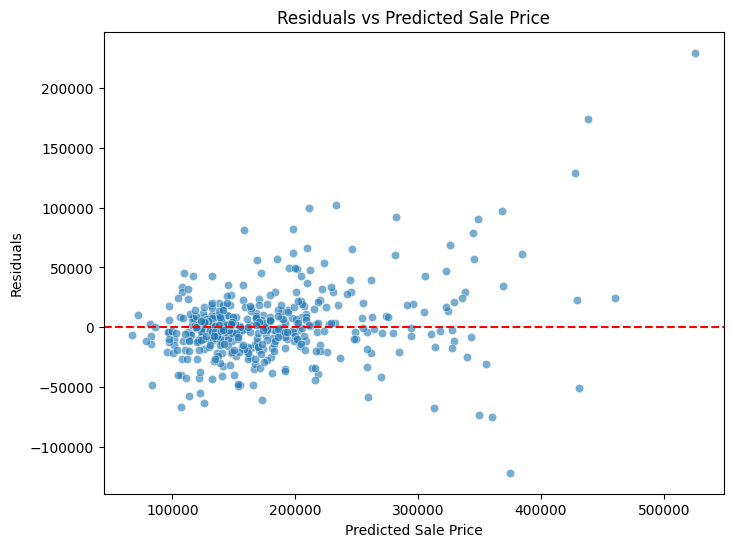

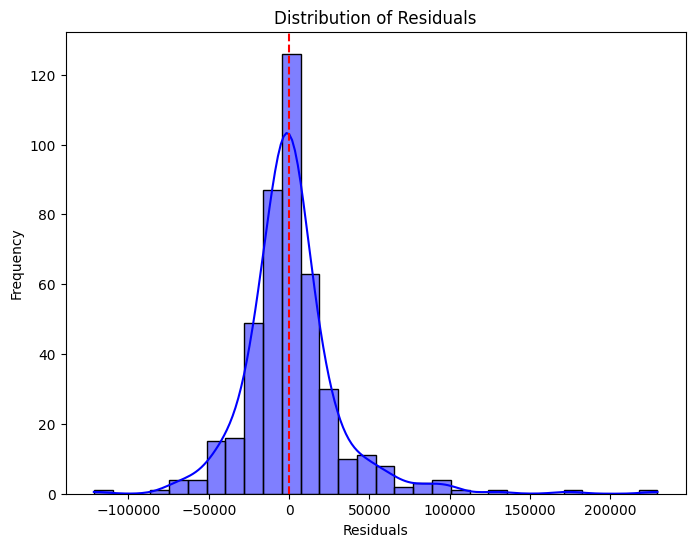

In [4]:
pipeline = Pipeline([
    ('model', XGBRegressor(random_state=42))  # Model to train
])

# Define the parameters for randomized search
param_grid = {
    'model__n_estimators': [100, 200, 300, 400],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 5, 10, 20],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0],
    'model__gamma': [0, 1, 5]
}


# Perform grid search for hyperparameters
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
best_params = grid_search.best_params_
print(f"Best hyperparameters from grid search: {best_params}")

# Retrieve the optimized model
optimized_model = grid_search.best_estimator_

# Make predictions with the optimized model
y_pred_optimized = optimized_model.predict(X_test)

# Calculate metrics without inverse log-transformation
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
r2_optimized = r2_score(y_test, y_pred_optimized)

print(f"Optimized MSE: {mse_optimized}")
print(f"Optimized R2 Score: {r2_optimized}")

# Residual analysis
residuals = y_test - y_pred_optimized

# Residuals vs Predicted Sale Price
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_optimized, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Sale Price")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Sale Price")
plt.show()

# Histogram of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True, color='blue')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best hyperparameters: {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 300}
Optimized MSE: 879756065.97
Optimized R2 Score: 0.8739


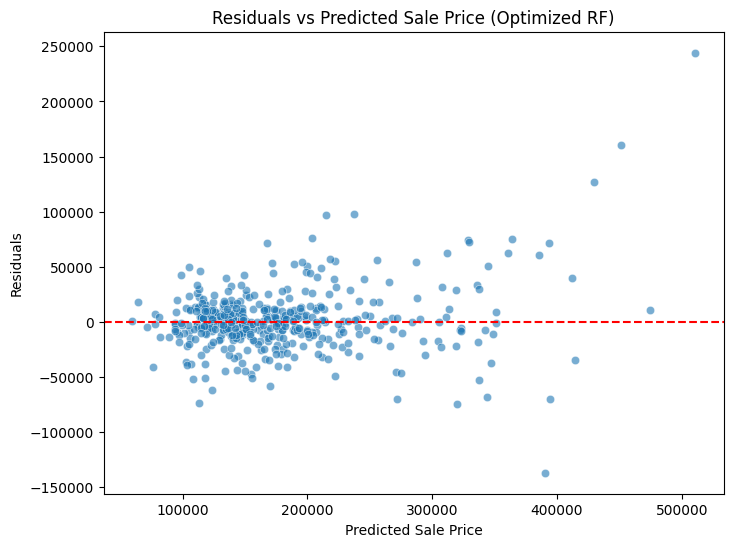

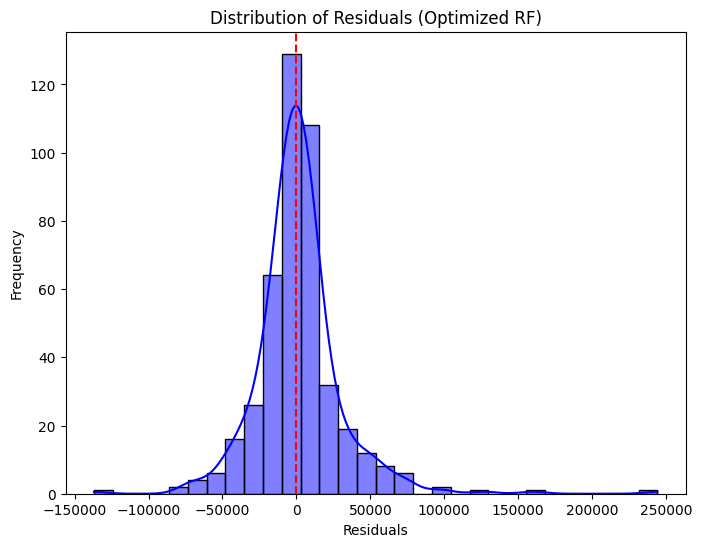

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Skapa en pipeline där 'model' är RandomForestRegressor
pipeline = Pipeline([
    ('model', RandomForestRegressor(random_state=42))
])

# Definiera ett parameterraster (param_grid) för RandomForest
param_grid = {
    'model__n_estimators': [100, 200, 300],  # Hur många träd
    'model__max_depth': [None, 5, 10, 20],   # Maxdjup per träd
    'model__min_samples_split': [2, 5, 10],  # Min antal sampels innan split
    'model__min_samples_leaf': [1, 2, 4],    # Min antal sampels i ett blad
    'model__max_features': ['sqrt', 'log2', 0.5]  # Hur många features som testas per split
}

# Starta en GridSearchCV (eller RandomizedSearchCV om du föredrar det)
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,            # 5-fold cross-validation
    n_jobs=-1,       # Använd alla tillgängliga kärnor
    verbose=1,       # Skriv ut mer info i konsollen
    scoring='r2'     # Skattar R²
)

# Kör grid search på träningsdatan
grid_search.fit(X_train, y_train)

# Presentera de bästa hyperparametrarna
print(f"Best hyperparameters: {grid_search.best_params_}")

# Hämta den bästa modellen
optimized_model = grid_search.best_estimator_

# Gör prediktioner på testdatan med den optimerade modellen
y_pred_optimized = optimized_model.predict(X_test)

# Beräkna MSE och R²
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
r2_optimized = r2_score(y_test, y_pred_optimized)

print(f"Optimized MSE: {mse_optimized:.2f}")
print(f"Optimized R2 Score: {r2_optimized:.4f}")

# Plotta residualer (valfritt, samma som i dina övriga celler)
residuals = y_test - y_pred_optimized

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_optimized, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Sale Price")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Sale Price (Optimized RF)")
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True, color='blue')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals (Optimized RF)")
plt.show()


##### **Gradient Boosting Regressor optimization**

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Best hyperparameters from grid search: {'model__learning_rate': 0.01, 'model__max_depth': 10, 'model__min_samples_leaf': 4, 'model__min_samples_split': 10, 'model__n_estimators': 300, 'model__subsample': 0.8}
Optimized MSE: 938552268.6386148
Optimized R2 Score: 0.8655001923458996


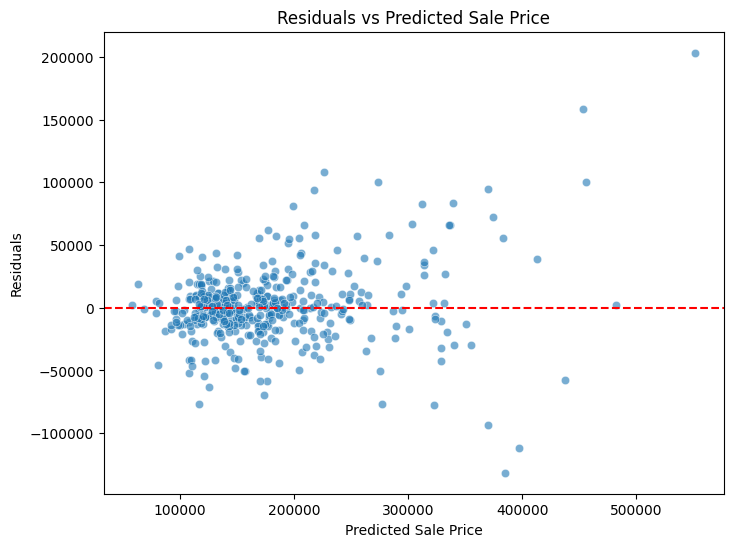

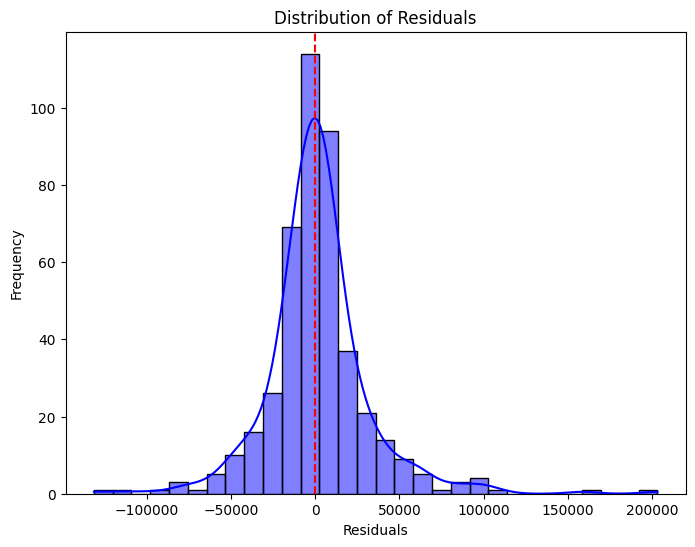

In [5]:
pipeline = Pipeline([
    ('model', GradientBoostingRegressor(random_state=42))  # Model to train
])

# Define the parameters for randomized search
param_grid = {
    'model__n_estimators': [100, 200, 300, 400],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 5, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__subsample': [0.8, 1.0]
}

# Perform grid search for hyperparameters
grid_search = GridSearchCV(
    pipeline, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring='r2'
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found and evaluate the model
print(f"Best hyperparameters from grid search: {grid_search.best_params_}")

# Retrieve the optimized model
optimized_model = grid_search.best_estimator_

# Make predictions with the optimized model
y_pred_optimized = optimized_model.predict(X_test)

# Calculate metrics without log-transformation
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
r2_optimized = r2_score(y_test, y_pred_optimized)

print(f"Optimized MSE: {mse_optimized}")
print(f"Optimized R2 Score: {r2_optimized}")

# Residual analysis
residuals = y_test - y_pred_optimized

# Residuals vs Predicted Sale Price
residuals = y_test - y_pred_optimized
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_optimized, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Sale Price")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Sale Price")
plt.show()

# Distribution of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='blue')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()


#### **Conclusion:**

All three models did really well and passed the business goal of R2 ≥ 0.75. Among them, the **RandomForestRegressor** did a bit better than the **Gradient Boosting Regressor** and **XGBRegressor** in terms of both R2 and MSE, making it the most accurate model in this test.



- **R2 Score**:
  - **RandomForestRegressor**: 0.8739
  - **Gradient Boosting Regressor**: 0.8655
  - **XGBRegressor**: 0.8692

  **RandomForestRegressor** has the highest R2 score, showing it can explain the most changes in house prices out of the three.

- **Mean Squared Error (MSE)**:
  - **RandomForestRegressor**: 879,756,065.97
  - **Gradient Boosting Regressor**: 938,552,268.64
  - **XGBRegressor**: 912,464,666.15

  **RandomForestRegressor** also has the lowest MSE, meaning its predictions are the closest to the real sale prices.

#### **Decision**:
Because it performed the best in both measures, **RandomForestRegressor** is chosen as the final model for predicting house prices. Both **Gradient Boosting Regressor** and **XGBRegressor** are still good choices for different needs.

In [6]:
# Save the optimized RandomForest model
dump(grid_search.best_estimator_, 'outputs/best_model/optimized_random_forest_model.pkl')
print("Optimized RandomForest model saved successfully.")

# Save the optimized Gradient Boosting model
dump(grid_search.best_estimator_, 'outputs/best_model/optimized_gradient_boosting_model.pkl')
print("Optimized Gradient Boosting model saved successfully.")

# Save the optimized XGBoost model
xgb_model = grid_search.best_estimator_
dump(xgb_model, 'outputs/best_model/optimized_xgboost_model.pkl')
print("Optimized XGBoost model saved successfully.")

Optimized RandomForest model saved successfully.
Optimized Gradient Boosting model saved successfully.
Optimized XGBoost model saved successfully.


___

### Visualizing Optimized Gradient Boosting Regressor Performance

The following visualizations show how well the optimized Gradient Boosting Regressor predicts house prices:

1. **Actual vs Predicted Sale Price**: This scatter plot compares the actual sale prices with the predicted sale prices. Points close to the red line indicate good predictions.
2. **Residuals vs Predicted Sale Price**: This plot shows the residuals (errors) for each prediction. Residuals centered around zero indicate a well-performing model.

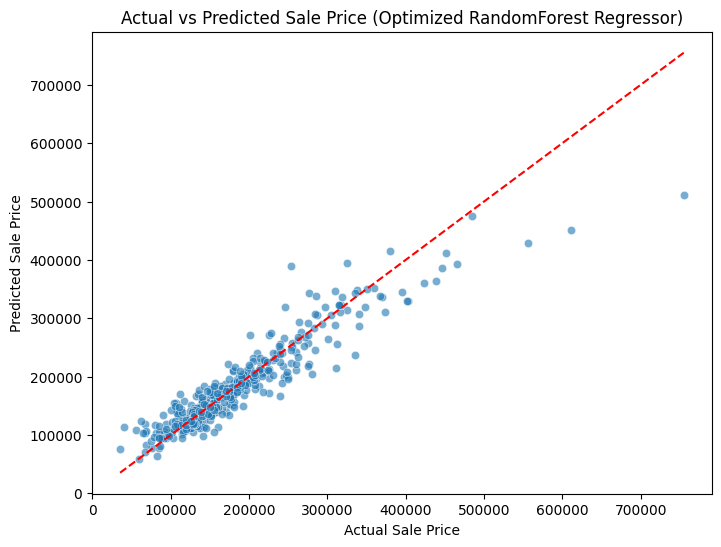

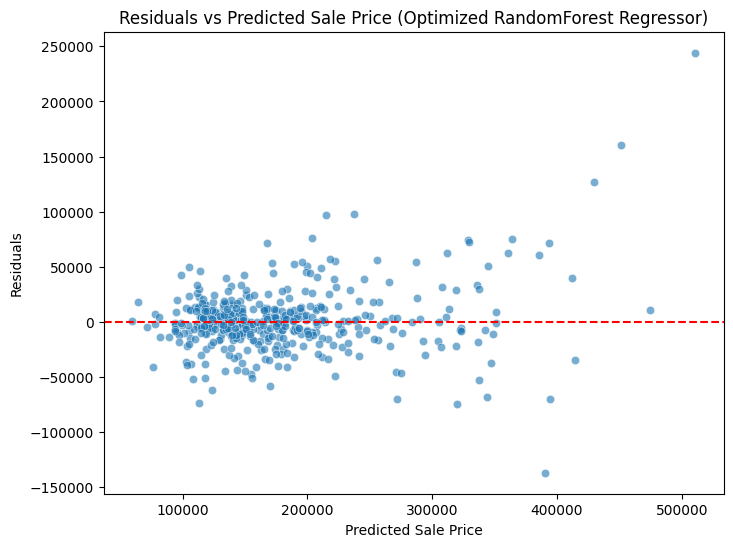

Model used for predictions: Optimized RandomForest Regressor


In [7]:
# After optimization of Gradient Boosting
optimized_model = grid_search.best_estimator_  # Model from Grid Search
y_pred_optimized = optimized_model.predict(X_test)  # Predicted values after optimization
model_name = "Optimized RandomForest Regressor"  # Updated model name

# Plot predicted vs actual values after optimization
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_optimized, alpha=0.6)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color='red',
    linestyle='--'
)  # Diagonal line for perfect prediction
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title(f"Actual vs Predicted Sale Price ({model_name})")
plt.show()

# Scatter plot of residuals vs predicted values
residuals_optimized = y_test - y_pred_optimized
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_optimized, y=residuals_optimized, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Sale Price")
plt.ylabel("Residuals")
plt.title(f"Residuals vs Predicted Sale Price ({model_name})")
plt.show()

print(f"Model used for predictions: {model_name}")


The plots look good overall. The "Actual vs Predicted" plot shows that most predictions are close to the line, indicating the model performs well. The "Residuals vs Predicted" plot shows that residuals are mostly centered around zero, with no obvious pattern, suggesting the model doesn't have systematic errors. There are a few outliers on more expensive houses, but overall, these visualizations provide a clear summary of the model's performance after optimization.